# Functionality benchmarks - Object detection

In [ ]:
# Imports and setup
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from ultralytics import YOLO

/Users/evgeniia-r/Desktop/emai/SAPIENZA/hri/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True

## Object Detection with YOLO

In [2]:
yolo_model = YOLO('yolov8n.pt')


In [3]:
def detect_objects(img_path, yolo_model):
    frame = cv2.imread(img_path)
    if frame is None:
        raise ValueError(f"Could not load image: {img_path}")
    results = yolo_model(frame)
    objects = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = yolo_model.model.names[int(box.cls)]
            conf = float(box.conf)
            if conf < 0.3:
                continue
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            objects.append({
                'label': label,
                'confidence': conf,
                'bbox': (x1, y1, x2, y2),
                'center_2d': (cx, cy)
            })
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(
                frame, f"{label} {conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2
            )
    return frame, objects

def show_img(img_path):
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(img_path)
    plt.axis('off')
    plt.show()

def show_img_objects(frame, objects):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Detection")
    plt.axis('off')
    plt.show()

### Benchmarking

Using COCO dataset to evaluate precision and recal of the selected approach for object detection part of the task. Computing metrics only for subset of images with the interior since it is more revelant to dancing robot setting.

In [35]:
import json
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import tempfile
import os

class COCOYOLOEvaluator:
    def __init__(self, annotation_file, conf_threshold=0.3):
        self.coco_gt = COCO(annotation_file)
        self.conf_threshold = conf_threshold
        self.categories = self.coco_gt.loadCats(self.coco_gt.getCatIds())
        self.category_names = [cat['name'] for cat in self.categories]
        self.name_to_id = {cat['name']: cat['id'] for cat in self.categories}
        
        print(f"Loaded COCO dataset with {len(self.coco_gt.getImgIds())} images")
        print(f"Categories: {len(self.categories)} classes")
        print(f"Categories: {self.categories}")

    def get_indoor_categories(self):
        indoor_categories = [
            'chair', 'couch', 'bed', 'tv',
            'microwave', 'oven', 'toaster', 'refrigerator'
        ]
        
        valid_indoor = []
        for cat in indoor_categories:
            if cat in self.name_to_id:
                valid_indoor.append(cat)
        
        print(f"Indoor categories found: {len(valid_indoor)}")
        print(f"Categories: {valid_indoor}")
        return valid_indoor

    def get_indoor_images(self, max_images=None):
        indoor_cats = self.get_indoor_categories()
        indoor_cat_ids = [self.name_to_id[cat] for cat in indoor_cats]
    
        indoor_img_ids = set()
        for cat_id in indoor_cat_ids:
            img_ids = self.coco_gt.getImgIds(catIds=[cat_id])
            indoor_img_ids.update(img_ids)
        
        indoor_img_list = list(indoor_img_ids)
        if max_images:
            indoor_img_list = indoor_img_list[:max_images]
        
        print(f"Found {len(indoor_img_list)} images with indoor objects")
        return indoor_img_list
    
    def convert_yolo_to_coco_format(self, yolo_predictions, image_id):
        coco_results = []
        indoor_cats = self.get_indoor_categories()
        
        for pred in yolo_predictions:
            if pred['confidence'] < self.conf_threshold:
                continue
            if pred['label'] not in self.name_to_id:
                continue
            if pred['label'] not in indoor_cats:
                continue
                
            category_id = self.name_to_id[pred['label']]
            
            # сonvert bbox from (x1, y1, x2, y2) to (x, y, width, height)
            x1, y1, x2, y2 = pred['bbox']
            bbox = [x1, y1, x2 - x1, y2 - y1]
            
            coco_result = {
                'image_id': image_id,
                'category_id': category_id,
                'bbox': bbox,
                'score': pred['confidence']
            }
            coco_results.append(coco_result)
        
        return coco_results
    

    def evaluate_model_with_examples(self, yolo_model, coco_images_dir, max_images=None):
        image_ids = self.get_indoor_images(max_images)
        self.examples = []
        self.example_metrics = []
        
        all_predictions = []
        processed = 0
        
        for img_id in image_ids:
            img_info = self.coco_gt.loadImgs(img_id)[0]
            img_path = os.path.join(coco_images_dir, img_info['file_name'])
            
            frame, objects = detect_objects(img_path, yolo_model)
            if len(self.examples) < 5:
                image_metrics = self._calculate_image_metrics(img_id, objects)
                example_data = {
                    'image_id': img_id,
                    'image_path': img_path,
                    'original_image': cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),
                    'detection_image': cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
                    'objects': objects,
                    'metrics': image_metrics,
                    'file_name': img_info['file_name']
                }
                
                self.examples.append(example_data)
                self.example_metrics.append(image_metrics)
    
            coco_preds = self.convert_yolo_to_coco_format(objects, img_id)
            all_predictions.extend(coco_preds)
            
            processed += 1
        
        print(f"Generated {len(all_predictions)} predictions from {processed} indoor images")
        
        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
            json.dump(all_predictions, f)
            results_file = f.name
        
        
        coco_dt = self.coco_gt.loadRes(results_file)
        coco_eval = COCOeval(self.coco_gt, coco_dt, 'bbox')
        coco_eval.params.imgIds = image_ids
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        
        self.show_examples()
        
        return coco_eval
            

    def _calculate_image_metrics(self, img_id, predictions):
        ann_ids = self.coco_gt.getAnnIds(imgIds=img_id)
        anns = self.coco_gt.loadAnns(ann_ids)
        indoor_cats = self.get_indoor_categories()
        gt_count = 0
        for ann in anns:
            cat_name = self.coco_gt.loadCats(ann['category_id'])[0]['name']
            if cat_name in indoor_cats and not ann.get('iscrowd', 0):
                gt_count += 1
        
        valid_preds = 0
        indoor_predictions = []
        for pred in predictions:
            if pred['confidence'] >= self.conf_threshold and pred['label'] in indoor_cats:
                valid_preds += 1
                indoor_predictions.append(pred)
        
        return {
            'ground_truth_count': gt_count,
            'prediction_count': valid_preds,
            'confidence_avg': np.mean([p['confidence'] for p in indoor_predictions]) if indoor_predictions else 0, 
            'detected_categories': list(set([p['label'] for p in indoor_predictions]))
        }

    def show_examples(self):
        for example in self.examples:
            print(example['file_name'])
            print(f"Detected objects: {len(example['objects'])}")
            print(f"Categories: {example['metrics']['detected_categories']}")
            print(f"ground-truth count: {example['metrics']['ground_truth_count']}")
            
            show_img(example['image_path'])
            show_img_objects(example['detection_image'], example['objects'])
    
    def print_detailed_results(self, coco_eval):
        print("results")

        stats = coco_eval.stats
        print(f"Average Precision @[IoU=0.50:0.95] = {stats[0]:.3f}")
        print(f"Average Recall @[IoU=0.50:0.95] = {stats[11]:.3f}")


loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
Loaded COCO dataset with 5000 images
Categories: 80 classes
Categories: [{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'anim

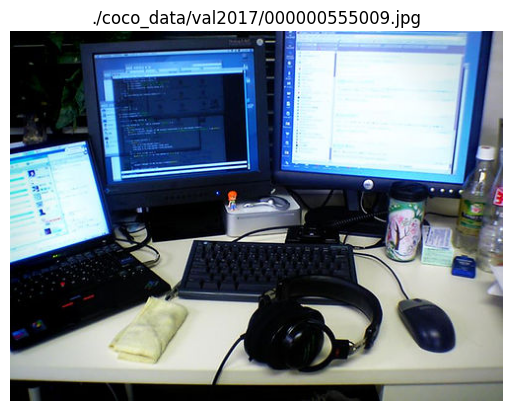

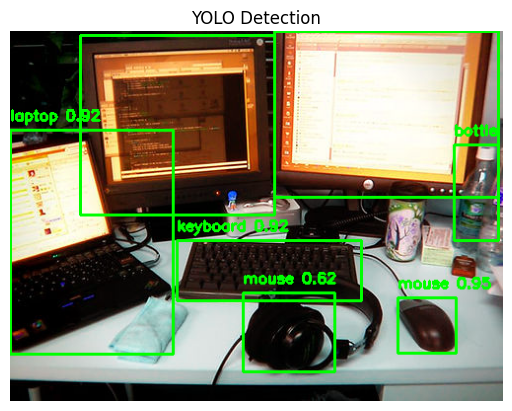

000000241668.jpg
Detected objects: 2
Categories: []
ground-truth count: 1


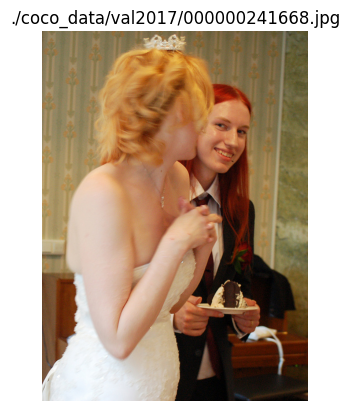

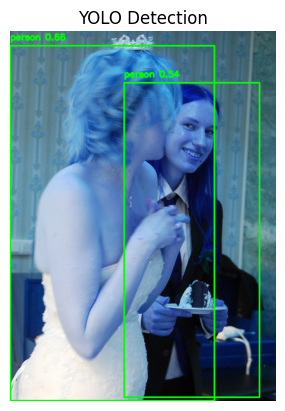

000000311303.jpg
Detected objects: 7
Categories: []
ground-truth count: 2


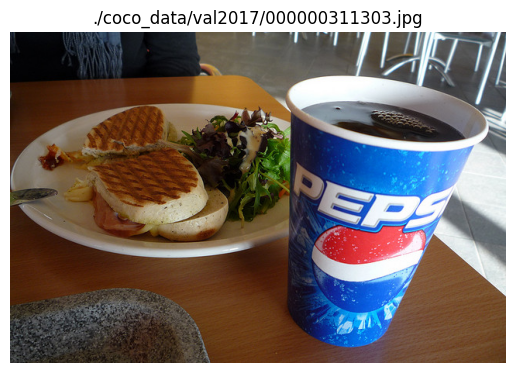

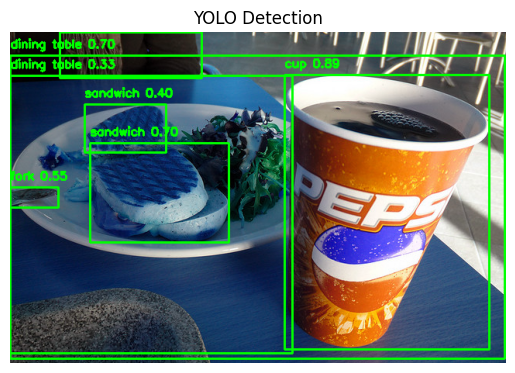

000000047112.jpg
Detected objects: 7
Categories: ['chair']
ground-truth count: 8


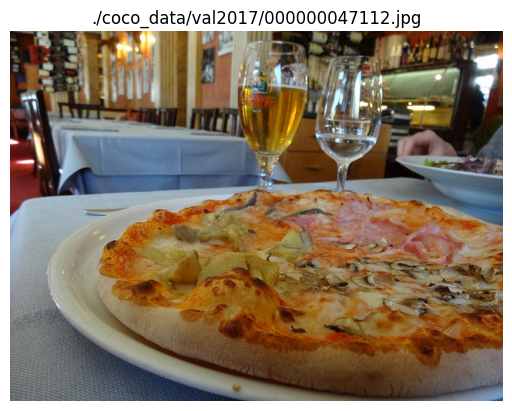

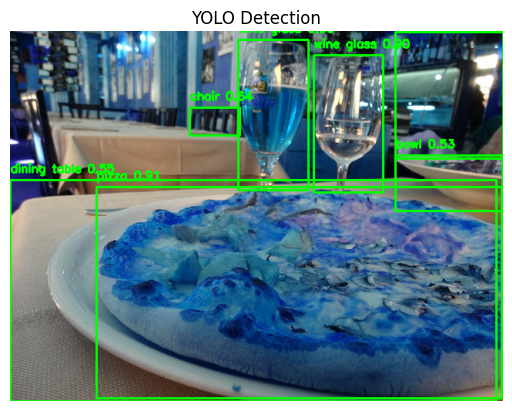

000000458768.jpg
Detected objects: 3
Categories: ['couch', 'oven']
ground-truth count: 4


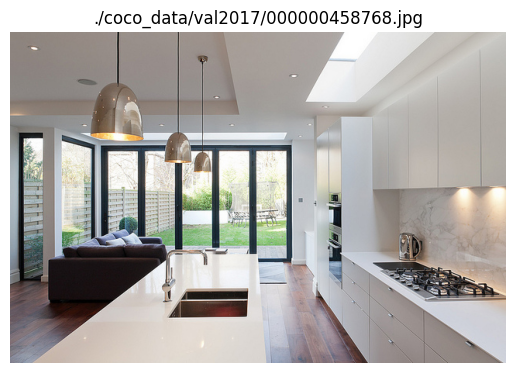

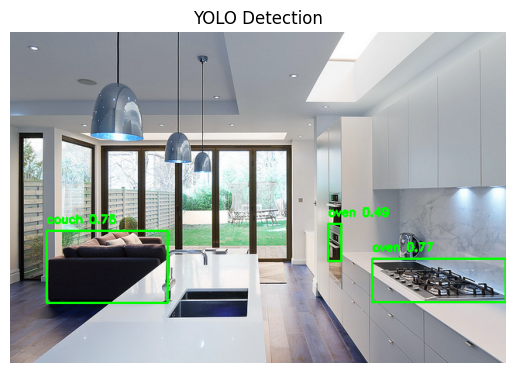

results
Average Precision @[IoU=0.50:0.95] = 0.063
Average Recall @[IoU=0.50:0.95] = 0.129


In [36]:

annotation_file = "./coco_data/annotations/instances_val2017.json"
coco_images_dir = "./coco_data/val2017"

evaluator = COCOYOLOEvaluator(annotation_file, conf_threshold=0.3)


coco_eval = evaluator.evaluate_model_with_examples(
    yolo_model=yolo_model,
    coco_images_dir=coco_images_dir,
    max_images=10
)

evaluator.print_detailed_results(coco_eval)
